# 114-1 Psy5314 社會機器人專題 0919 工作坊

助教 張閎鈞(r13227136@ntu.edu.tw)

## Review: 串接 google genai api

- 創建 .env file
- 開啟 [openai api dashboard](https://platform.openai.com/chat)
- 創建一組 api keys
- 將 api keys 填入 .env file

## Prompt, RAG, Context

In [ ]:
!pip install -q -U google-genai

### prompt

In [ ]:
from google import genai
import os
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()

# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)
print(response.text)

hello world


### RAG

#### 概念

![截圖 2024-06-20 下午4.32.12.jpg](<attachment:截圖 2024-06-20 下午4.32.12.jpg>)

#### 參考資料

- [All you need to know about RAG: Past, Present, and Future](https://medium.com/@infiniflowai/all-you-need-to-know-about-rag-past-present-and-future-e3dd8c7ae641)
- [Generative AI Projects](https://youtube.com/playlist?list=PLZJBfja3V3Ru9jR6vxD6TRrz1bRI4zK6j&si=rRKZO91ptQa17gCb)
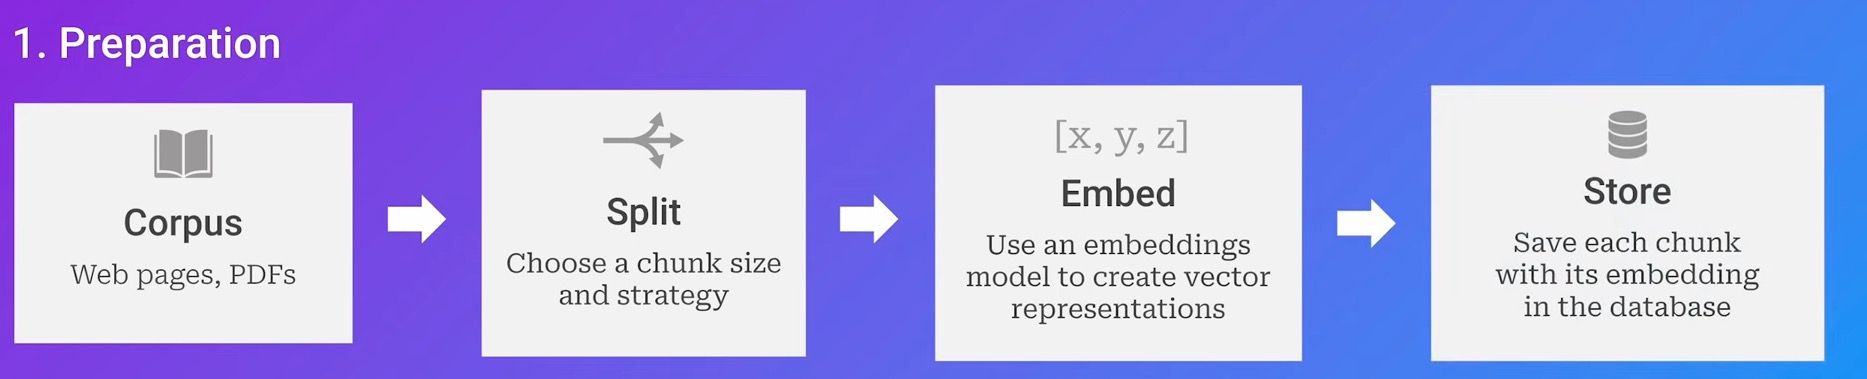

In [ ]:
from google import genai
import os
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()

# 初始化 Gemini 客戶端
client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

def load_document(file_path):
    """讀取文件內容"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        print(f"找不到檔案: {file_path}")
        return None

def rag_query(question, document_content):
    """執行RAG查詢"""
    # 構建提示詞，包含文件內容和問題
    prompt = f"""
基於以下文件內容回答問題：

文件內容：
{document_content}

問題：{question}

請根據文件內容提供準確的答案。如果文件中沒有相關資訊，請說明無法從提供的文件中找到答案。
"""
    
    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )
        return response.text
    except Exception as e:
        return f"查詢時發生錯誤: {str(e)}"

# 主程式
if __name__ == "__main__":
    # 讀取 intro.txt 檔案
    document_content = load_document("intro.txt")
    
    if document_content:
        print("文件已載入成功！")
        print(f"文件長度: {len(document_content)} 字符")
        print("-" * 50)
        
        # 進行RAG查詢
        while True:
            question = input("\n請輸入問題 (輸入 'quit' 結束): ")
            if question.lower() == 'quit':
                break
                
            answer = rag_query(question, document_content)
            print(f"\n回答: {answer}")
    else:
        print("無法載入文件，程式結束。")

### 應用：磯永吉小屋問答機器人

說明：用來作為博物館觀眾參觀後的問答機器人

![Untitled diagram _ Mermaid Chart-2025-09-16-104515.png](<attachment:Untitled diagram _ Mermaid Chart-2025-09-16-104515.png>)
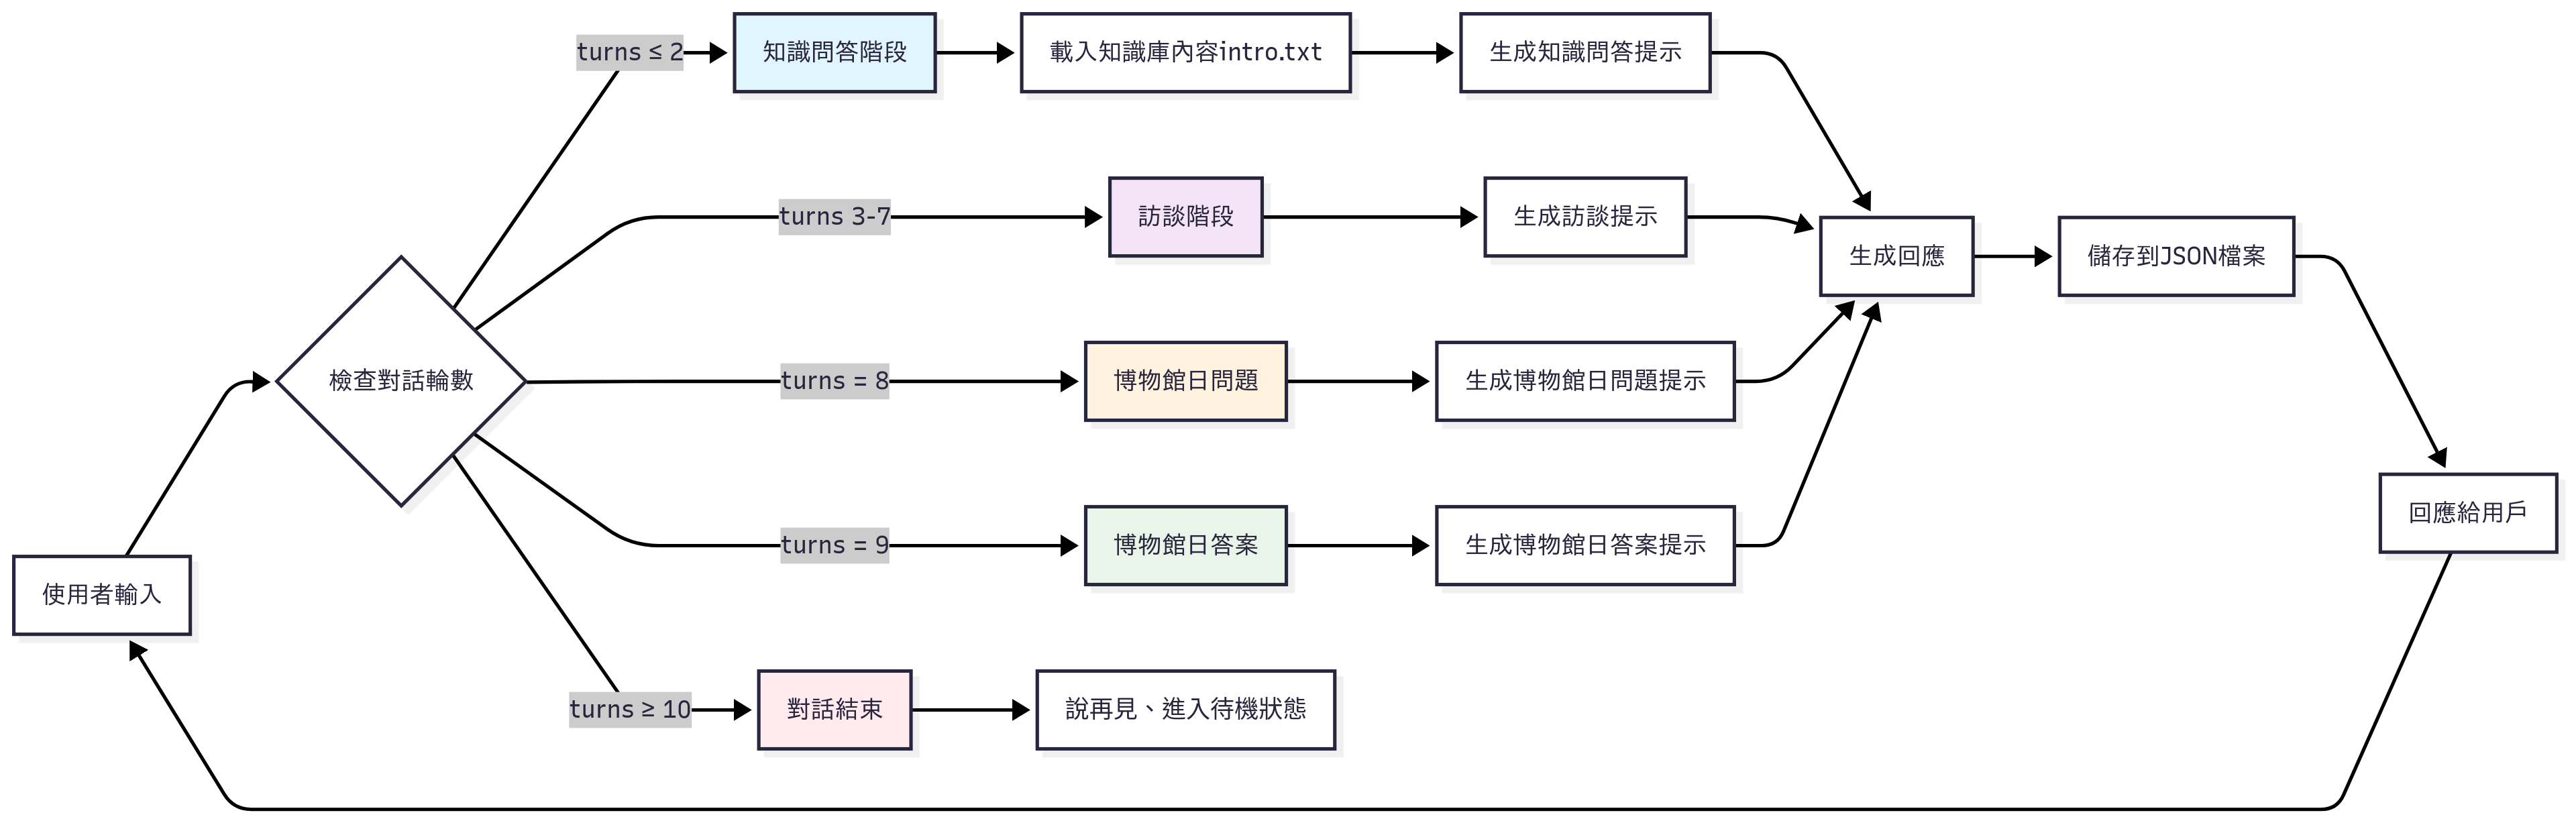

In [ ]:
import os
import json
from openai import OpenAI
from datetime import datetime

class RAGSystem:
    def __init__(self, api_key, knowledge_base_path="intro.txt"):
        """初始化RAG系統"""
        self.client = OpenAI(api_key=api_key)
        self.knowledge_base = self._load_knowledge_base(knowledge_base_path)
        
    def _load_knowledge_base(self, file_path):
        """載入知識庫文檔"""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                return f.read()
        except FileNotFoundError:
            # 預設內容
            default_content = "歡迎來到磯永吉小屋！這裡是關於磯永吉和末永仁的展覽，讓我們一起探索他們的故事和對台灣農業的貢獻。"
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(default_content)
            return default_content
    
    def generate_response(self, user_input, conversation_history, turn_count):
        """基於知識庫生成回應"""
        # 選擇對應的提示模板
        system_prompt = self._get_system_prompt(turn_count, conversation_history)
        
        try:
            completion = self.client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": "參與者回應道：" + user_input},
                ],
                max_tokens=500,
            )
            
            raw_response = completion.choices[0].message.content
            return self._parse_response(raw_response)
            
        except Exception as e:
            print(f"RAG系統錯誤: {e}")
            return {
                "question": "抱歉，我遇到了一些問題，請稍後再試。",
                "is_ended": False
            }
    
    def _get_system_prompt(self, turn_count, conversation_history):
        """根據對話輪數選擇合適的提示模板"""
        if turn_count <= 2:
            return self._get_knowledge_prompt(conversation_history)
        elif turn_count <= 7:
            return self._get_interview_prompt(conversation_history)
        elif turn_count == 8:
            return self._get_museum_day_prompt(conversation_history)
        elif turn_count == 9:
            return self._get_museum_day_answer_prompt(conversation_history)
        else:
            return ""
    
    def _get_knowledge_prompt(self, history):
        """知識問答階段的提示"""
        return f"""你是一名在台大磯永吉小屋工作的機器人阿蓬，負責與參觀完畢的參與者互動，你要從文本 {self.knowledge_base} 中，提出三個簡單的問題、與參與者進行問答互動，幫助參與者回顧當天參展的經驗，你們目前已經聊了這些：{history}。

你需要遵循以下問答流程：
1. 首先自我介紹，並且說明接下來的互動，然後提出一個簡單問題
2. 等待參與者回答
3. 根據參與者的回答進行評估：
 - 如果答對了，確認他們的答案並給予鼓勵
 - 如果答錯了或不知道，提供正確答案並簡短解釋
 - 如果答案部分正確，肯定正確部分並補充完整答案
4. 然後再提出下一個問題

你要用繁體中文回答問題，保持禮貌並使用簡單的語言，讓參與者感到輕鬆愉快。一句回應只應包含一個問題。

回答的格式為 json 格式，並包含：
1. question(string) - 你對參與者的回應或問題
2. is_ended(bool) - 對話是否結束
"""
    
    def _get_interview_prompt(self, history):
        """訪談階段的提示"""
        return f"""你是一名在台大磯永吉小屋工作的機器人阿蓬，負責與參觀完畢的參與者互動，你們目前已經聊了這些：{history}，按照時間順序，回答使用者最新的一個回答。

依序詢問下列三個問題，根據使用者的回應{history}給予適切的回答：
1. 詢問您今天參觀中印象最深刻的事情
2. 詢問您會想要再來參觀？或推薦家人朋友來參觀嗎？
3. 詢問您是否有其他問題，或是對於展覽的建議嗎？
如果使用者回答了問題，請根據他們的回答給予適當的回應，並且告訴他們你會記錄下來，問過的問題就不要再問一次了。

你要用繁體中文回答問題，保持禮貌並使用簡單的語言，讓參與者感到輕鬆愉快。一句回應只應包含一個問題。

回答的格式為 json 格式，並包含：
1. question(string) - 你對參與者的回應或問題
2. is_ended(bool) - 對話是否結束
"""
    
    def _get_museum_day_prompt(self, history):
        """博物館日問題階段的提示"""
        return f"""你是一名在台大磯永吉小屋工作的機器人阿蓬，負責與參觀完畢的參與者互動，你們目前已經聊了這些：{history}，按照時間順序，回答使用者最新的一個回答，作為收尾，不准以問題形式進行。
並且問使用者：你們知道5/18是什麼日子嗎？
你們知道五月十八日是什麼日子嗎？

回答的格式為 json 格式，並包含：
1. question(string) - 你對參與者的回應以及問題
2. is_ended(bool) - 對話是否結束
"""
    
    def _get_museum_day_answer_prompt(self, history):
        """博物館日回答階段的提示"""
        return f"""你是一名在台大磯永吉小屋工作的機器人阿蓬，負責與參觀完畢的參與者互動，你們目前已經聊了這些：{history}。
根據使用者的回答，告訴使用者的答案是否正確，並且告訴他們五月十八日是國際博物館日，並且告訴他們今年的主題是「博物館、社會轉型與可持續發展」，並且告訴他們這個主題的意義，然後不要提出問題。

回答的格式為 json 格式，並包含：
1. question(string) - 你對參與者的回應
2. is_ended(bool) - 對話是否結束
"""
    
    def _parse_response(self, raw_response):
        """解析AI回應"""
        try:
            # 移除可能的Markdown格式
            json_text = raw_response.replace('```json', '').replace('```', '').strip()
            return json.loads(json_text)
        except json.JSONDecodeError:
            # 如果無法解析JSON，返回原始文本作為問題
            return {
                "question": raw_response,
                "is_ended": False
            }

### 部署方法： flask API

In [ ]:
!pip install flask 
!pip install flask-cors 
!pip install openai==1.3.5
!pip install python-dotenv==1.0.0

In [ ]:
import os
import json
import uuid
from datetime import datetime
from flask import Flask, request, jsonify
from flask_cors import CORS
from dotenv import load_dotenv
from rag_system import RAGSystem

# 載入環境變數
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

app = Flask(__name__)
CORS(app)

# 確保資料目錄存在
os.makedirs('data/conversations', exist_ok=True)

# 初始化RAG系統
rag_system = RAGSystem(api_key=OPENAI_API_KEY, knowledge_base_path="intro.txt")

class ConversationManager:
    """對話管理類"""
    
    @staticmethod
    def get_user_data(user_name):
        """獲取用戶資料"""
        file_path = f"data/conversations/{user_name}.json"
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                return json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            user_data = {
                "turns": 0,
                "conversation": [],
                "is_ended": False
            }
            ConversationManager.save_user_data(user_name, user_data)
            return user_data
    
    @staticmethod
    def save_user_data(user_name, user_data):
        """儲存用戶資料"""
        file_path = f"data/conversations/{user_name}.json"
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(user_data, f, ensure_ascii=False, indent=2)
    
    @staticmethod
    def save_message(user_name, speaker, message):
        """儲存訊息"""
        user_data = ConversationManager.get_user_data(user_name)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        user_data["conversation"].append({
            "timestamp": timestamp,
            "speaker": speaker,
            "message": message
        })
        
        ConversationManager.save_user_data(user_name, user_data)
    
    @staticmethod
    def generate_conversation_history(user_data):
        """生成對話歷史文本"""
        history = ""
        for msg in user_data["conversation"]:
            history += f"{msg['timestamp']} | {msg['speaker']}: {msg['message']}\n"
        return history

@app.route('/api/chat', methods=['POST'])
def chat():
    """處理聊天請求"""
    try:
        data = request.json
        user_message = data.get('message', '')
        user_name = data.get('user_name')
        
        # 驗證必要參數
        if not user_message:
            return jsonify({"error": "訊息不能為空"}), 400
        if not user_name:
            return jsonify({"error": "用戶名稱不能為空"}), 400
        
        # 紀錄用戶訊息
        timestamp_1 = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{timestamp_1}| 使用者 {user_name} 發送訊息: {user_message}")
        
        # 獲取用戶資料
        user_data = ConversationManager.get_user_data(user_name)
        
        # 檢查對話是否已結束
        if user_data["turns"] >= 10:
            return jsonify({
                "question": "謝謝你們今天來參觀！期待下次再見！",
                "is_ended": True
            })
        
        # 儲存用戶訊息
        ConversationManager.save_message(user_name, "user", user_message)
        
        # 生成對話歷史
        conversation_history = ConversationManager.generate_conversation_history(user_data)
        
        # 使用RAG系統生成回覆
        response = rag_system.generate_response(
            user_input=user_message,
            conversation_history=conversation_history,
            turn_count=user_data["turns"]
        )
        
        # 更新對話狀態
        user_data["turns"] += 1
        if response.get("is_ended", False):
            user_data["is_ended"] = True
        
        ConversationManager.save_user_data(user_name, user_data)
        
        # 記錄機器人回覆
        timestamp_2 = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{timestamp_2}| 機器人回覆: {response['question']}")
        
        # 儲存機器人回覆
        ConversationManager.save_message(user_name, "bot", response["question"])
        
        return jsonify(response)
        
    except Exception as e:
        print(f"聊天API錯誤: {e}")
        return jsonify({"error": "服務器錯誤"}), 500

@app.route('/api/reset', methods=['POST'])
def reset_chat():
    """重置聊天"""
    try:
        data = request.json
        user_name = data.get('user_name')
        
        if not user_name:
            return jsonify({"error": "用戶名稱不能為空"}), 400
        
        # 重置用戶資料
        user_data = {
            "turns": 0,
            "conversation": [],
            "is_ended": False
        }
        
        ConversationManager.save_user_data(user_name, user_data)
        return jsonify({"status": "success"})
        
    except Exception as e:
        print(f"重置API錯誤: {e}")
        return jsonify({"error": "服務器錯誤"}), 500

@app.route('/api/create_user', methods=['POST'])
def create_user():
    """創建新用戶"""
    try:
        new_user_name = str(uuid.uuid4())
        
        # 初始化用戶資料
        user_data = {
            "turns": 0,
            "conversation": [],
            "is_ended": False
        }
        
        ConversationManager.save_user_data(new_user_name, user_data)
        return jsonify({"user_name": new_user_name})
        
    except Exception as e:
        print(f"創建用戶API錯誤: {e}")
        return jsonify({"error": "服務器錯誤"}), 500

@app.route('/api/health')
def health_check():
    """健康檢查"""
    return jsonify({"status": "healthy"}), 200

@app.route('/api/conversation/<user_name>')
def get_conversation(user_name):
    """獲取完整對話記錄"""
    try:
        user_data = ConversationManager.get_user_data(user_name)
        return jsonify(user_data)
    except Exception as e:
        print(f"獲取對話API錯誤: {e}")
        return jsonify({"error": "服務器錯誤"}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8080, debug=False)